# Raman Rabi Tutorial

# Taylor Patti, Jamelle Watson-Daniels, and Soumya Ghosh

This is a tutorial notebook for the `raman_rabi` package. This tutorial uses example data to demonstrate how the package can be used to perform parameter estimation on spin readout data. This package was developed for Prof. Manoharan's PHYS 201: Statistics for Physicists course at Harvard.


# What this package does

The `raman_rabi` package facilitates analysis of spin readout data from an NV center experiment. We want to know if the functional form of the electronic-nuclear flip-flop transition in the Raman-Rabi NV center protocol is indeed the form of a decaying exponential, as described in [arXiv:1808.04346](https://arxiv.org/abs/1808.04346). The data we are interested in is the change in $m_N = +1$ and $m_s = 0$ nuclear spin populations as a function of Raman-Rabi pulse length in Fig. 4.

It is hypothesized by the paper that this behavior is weakly driven, over-damped Raman-Rabi oscillations. That is, partial coherent transitions between the two nuclear spin populations marred by various sources of state decay and decoherence. The ideal theoretical model $I_T^{m_N}(t)$ proposed for the nuclear spin specific fluorescence for spin $m_N$ is described by

$$I_T^{m_N}(t) = B_G + A_p e^{-\Gamma_p t} + A_h \cos\left( \Omega_h t \right) e^{-\Gamma_{deph} t},$$

where $B_G$ is the background population/fluorescence, $A_p$ is the strength at which parasitic transitions remove states from the cycle (i.e. into $m_s = -1$ or $m_N = -1$ states, $\Gamma_p$ is the rate at which this parasitic loss occurs, $A_h$ is the strength at which the hyperfine interaction induces this transition, $\Omega_h$ is the rate at which the hyperfine transition occurs, and $\Gamma_{deph}$ is the rate of dephasing in this coherent oscillation. The units of $B_G$, $A_p$, and $A_h$ are arbitrary units of fluoresence (A.U.) and the units of $\Gamma_p$, $\Omega_h$, and $\Gamma_{deph}$ are inverse $\mu$s.

Note: 

Throughout the package, the model parameters reside in an array `theta` with the following convention: $$\theta =[B_G, A_p, \Gamma_p , A_h, \Omega_h , \Gamma_{deph}]$$ Be sure to define parameters in the correct order when `theta` is passed into any of the functions.

# Getting started

## Initial imports

Just putting together some stuff we'll want in order to visualize and manipulate our data.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

## Importing the package and testing

First, import the `raman_rabi` package and check that the `hello()` function returns a greeting:

In [2]:
import raman_rabi
print(raman_rabi.testing.hello())

>>> Hello from raman_rabi!


Now import the submodules: `RRDataContainer`, `rr_model`, and `rr_io`:

In [3]:
from raman_rabi import RRDataContainer
from raman_rabi import rr_model
from raman_rabi import rr_io

# Averaged (binned) Generative model

The simplest analysis that can be done with these data is one where we will average over all of our data points for each $m_S$ and then consider our full signal model as

$$I(t) = I_T^{m_N}(t) + \eta_{shot}(t)$$

where $\eta_{shot}(t)$ is a random variable describing the measurement shot noise. This is because the measurement is described by a Poisson distribution with mean $I_T^{m_N}(t)$. The magnitude of the shot noise is equal to the square root of the ideal signal. HOWEVER, as the fluoresence data is taken as a continuum (not single photon counting) we will take the limit of large counts of a Poissonian distribution and obtain a Gaussian for the data distribution with standard deviation (shot noise magnitude) of $\sqrt{I_T^{m_N}(t)}$.

We stress that this averaging (over all of the runs for each length of time pulse) is refered to in this work as binning. We bin all of the data points that correspond to the same length of applied pulse into a single data point in this model.

This model is encoded in the function `rr_model.likelihood_mN1`.

## Load data

First let's load some real (un-averaged) data using `RRDataContainer`:

In [4]:
testfilepath = rr_io.get_example_data_file_path("21.07.56_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout - -800 MHz, ND0.7 Vel1, Presel 6 (APD2, Win 3)_ID10708_image.txt")
s = RRDataContainer(testfilepath)
mN1_data = s

## Calculating the model prediction and likelihood
Consider the test data against the model with nominal parameters, determined in the previous work. In order to illustrate the suitability of this functional form for these test data, let's plot the model with nominal parameters against the fluorescence data averaged over all runs. 

The `rr_model.likelihood_mN1` function returns both the likelihood of the model given the data as well as the prediction of the model given the parameters. `rr_model.likelihood_mN1` requires parameters `mN1_data` (an `RRDataContainer` with the experimental data in question); `time_min` and `time_max` (floats which give the Raman-Rabi pulse duration in microseconds); `BG`, `Ap`, `Gammap`, `Ah`, `Omegah`, and `Gammadeph` (all floats which give the parameters of the model we discussed at the beginning of this tutorial).

First, let's use `rr_model.likelihood_mN1` to get a likelihood and a model prediction given the data we loaded above, as well as the nominal model parameters. The nominal model parameters are initialized as follows:

In [5]:
time_min = 0
time_max = 40
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871
dataN = 10
runN = 1200

Now we can calculate the likelihood and model prediction:

In [6]:
s_likelihood, prediction = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG, 
                                                   Ap, Gammap, Ah, Omegah, Gammadeph, dataN, runN)
#print(s_likelihood)
#print(prediction)

## Compare model to binned data 
In order to compare the model prediction to data, we need to bin our data. We'll choose the simplest binning scheme, simply averaging over all trials. We'll also define a conversion factor between the fluorescence readout and the actual number of nuclei to which it corresponds.

In [7]:
conversion = 1000 # conversion factor between fluorescence and number of nuclei
averaged_data = conversion*s.get_df().mean(axis=0)

And finally, let's plot everything and see how it looks:

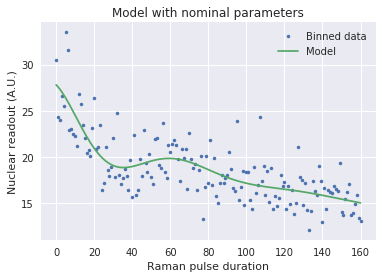

In [8]:
plt.plot(averaged_data, linestyle='None',marker='.', label = 'Binned data')
plt.plot(prediction, label = 'Model')
plt.title('Model with nominal parameters')
plt.xlabel('Raman pulse duration')
plt.ylabel('Nuclear readout (A.U.)')
plt.legend()
plt.show()

## Performing and visualizing likelihood scans

You can also scan through different values of a given parameter in `rr_model.likelihood_mN1` to get a sense of the likelihood function for that parameter. 

First, define the ranges you want to scan through using `numpy.linspace`:

In [9]:
npoints = 1000
BG_range = np.linspace(0,10,npoints)
gammap_range = np.linspace(-Gammap/2,2*Gammap,npoints)

Then step through the points in your likelihood scan, evaluating `rr_model.likelihood_mN1` at each point and storing the values in a list:

In [10]:
likelihoods_bg = []
likelihoods_gp = []
mus_bg = []
mus_gp = []
for i in range(npoints):
    bgLikelihood, mu1 = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG_range[i], Ap, Gammap, Ah, Omegah, Gammadeph, dataN, runN)
    likelihoods_bg.append(bgLikelihood)
    gpLikelihood, mu2 = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG, Ap, gammap_range[i], Ah, Omegah, Gammadeph, dataN, runN)
    likelihoods_gp.append(gpLikelihood)

And finally plot the likelihood against the parameter values you scanned through:

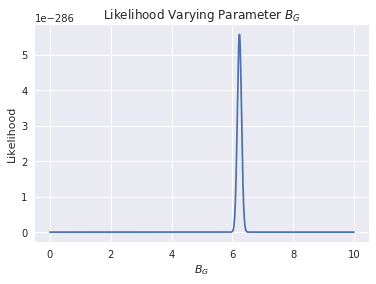

In [11]:
plt.plot(BG_range,likelihoods_bg)
plt.title(r"Likelihood Varying Parameter $B_G$")
plt.xlabel(r"$B_G$")
plt.ylabel("Likelihood")
plt.show()

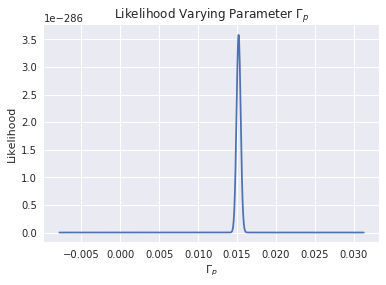

In [12]:
plt.plot(gammap_range,likelihoods_gp)
plt.title(r"Likelihood Varying Parameter $\Gamma_p$")
plt.xlabel(r"$\Gamma_p$")
plt.ylabel("Likelihood")
plt.show()

The values of $\Gamma_p$ and $B_G$ that maximize these likelihood scans correspond to the MAP values of these parameters with uniform priors for all parameters, as the likelihood function is proportional to the posterior.

In [13]:
print('>>> MAP value of B_G is', BG_range[np.argmax(likelihoods_bg)], 'A.U.')
print('>>> MAP value of Gamma_p is', gammap_range[np.argmax(likelihoods_gp)], ' us^-1')

>>> MAP value of B_G is 6.226226226226226 A.U.
>>> MAP value of Gamma_p is 0.015207613445576142  us^-1


# Unbinned Generative Model

Our generative model does not average over the data for each individual time step as the binned model does. However, we will still take the averaged data for each time step in order to estimate the magnitude of our shot-noise, such that, in the limit of many photons, the Poissonian distribution of our data becomes a Gaussian of variance $\sigma^2 = \lambda$.

We stress that by unbinned, we mean that each individual data point is individually part of the product of our likelihood function. In the binned model, we first average these points for each time step. Now in the unbinned model, we process the likelihood of each point independently for the loglikelihood function (which of course is a product of these).

Our model then becomes much like the unbinned model, except for that now it address each run number $i$ separately. That is $I(t)$ is still:

$$I(t) = I_T^{m_N}(t) + \eta_{shot}(t)$$

for an individual data point (where $I_T^{m_N}(t)$ is the ideal theoretical model as before). We can do this because our residuals can reasonably be assumed uncorrelated. In fact, data collection for each time step was done in a random order such that laser alignment drift and others typically systematic in time errors would be uncorrelated random noise. Therefore, $I(t)$ is once again a random Gaussian variable representing the expected signal along with shot noise uncertainty.

As the only deviation from our ideal model is shot noise, we use the deterministic Gaussian noise likelihood function

$$p(D|\theta, I) = \prod_{i=0}^N p(d_i|\theta, I) = \prod_{i=0}^N \frac{1}{\sqrt{2 \pi \lambda_t}} \exp\left(-(d_i - I(t))^2 / 2\lambda_t \right)$$

where $d_i$ is an individual data point at time $t$ and $\lambda$ is the mean of these data points for some time $t$ (that this the averaged estimate of shot noise variance).

## Creating test data with the generative model

The function `unbinned_log_likelihood_mN1` processes the unbinned data according to the model above. It returns the loglikelihood of the model as a function of our six parameters for an arbitrarily sized data set. This function is designed for MCMC analysis using `emcee.EnsembleSampler`, for which the function `rr_model.Walkers` is a convenient wrapper. `rr_model.Walkers` accepts parameters, initial guesses, and run specifications, and then returns the sampled data. `unbinned_log_likelihood_mN1` is used along with an internal set of log priors to calculate a log posterior for the model which `Walkers` explores.

In order to try out the MCMC sampling, you need to generate test data that represents the distribution modeled in our likelihood. This means that for large sample sizes of data and sufficient numbers of walkers and steps, you should obtain estimates which yield the model parameters that you assign in the generation of the test data. The function `rr_model.generate_test_data` allows you to do this conveniently.

First, pick some parameters. Recall, the model parameters reside in an array `theta`, which gets passed to `rr_model.generate_test_data`. You'll also need the number of time steps to use in the simulation, the number of trials to simulate, and the first and last time points in each trial in microseconds:

In [14]:
# a set of test parameter values
theta = np.array([6.10, 16.6881, 1/63.8806, 5.01886, -np.pi/8.77273, 1/8.5871])

Now use `rr_model.generate_test_data` to produce a sample using the parameters we just defined.

In [15]:
# generate a large data set using theta: 500 runs with 161 time steps each
dataN = 10
runN = 1200
test_data = rr_model.generate_test_data(theta, 
                                        161, # number of time steps 
                                        20, # number of trials
                                        0, 40, # first and last time point of each trial 
                                        dataN, runN) # dataN


Try calculating the log likelihood directly using `rr_model.unbinned_loglikelihood_mN1` on the test data you've generated and the parameters you used to generate them. Along with `theta` and the test data, this function needs the first and last time point of each trial and a boolean indicating whether these data were read in from a CSV file:

In [16]:
test_loglikelihood = rr_model.general_loglikelihood(theta, test_data, 0, 40, False, dataN, runN, 100*100, withlaserskew=False)
print("Log likelihood:", test_loglikelihood)

Log likelihood: -1583.6442838413843


## Using MCMC to estimate the parameters of the test dataset

Now run `rr_model.Walkers` on the test data to see if you can recover the parameters you used to generate the data. We've preselected a number of walkers and a number of steps which are manageable for most computers. `rr_model.Walkers` requires an initial guess of what you think your true parameters are, the first and last time points, a boolean indicating whether these data were read in from a CSV file. Optionally, you can specify `dataN` (an int indicating how many trials have been summed to produce the data), `scale_factor` (a double indicating the conversion factor from fluorescence readout to number of nuclei), `nwalkers` and `nsteps` (ints indicating the number of walkers and number of steps they should take, respectively).

In [27]:
#added more time and walkers
guesses = theta
numdim = len(guesses)
numwalkers = 200 #this isn't too many walkers, but just to keep this tutorial short to run
numsteps = 400 #this isn't too many steps, but just to keep this tutorial short to run
gaus_var = 1e-3
priors = [  ['uniform',0, +np.inf], # BG
                      ['uniform',0,+np.inf], # Ap
                      ['uniform',0.0,+np.inf], # Gammap
                      ['uniform',0,+np.inf], # Ah
                      ['uniform',-np.inf, 0],# Omegah
                      ['uniform',0.0,+np.inf]] # Gammadeph
test_samples = rr_model.Walkers_Sampler(test_data, guesses, 0, 40, False, dataN, runN, gaus_var, 
                                nwalkers=numwalkers, nsteps=numsteps, priors=priors)

### Check burn-in time
In order to check "burn-in" time now let's plot traces of the samples of the parameters.

/home/taylor/Documents/Classes/Data Analysis/Final Project/raman_rabi/raman_rabi/rr_model.py:307: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  df = sampler_to_dataframe(sampler, withlaserskew)
/home/taylor/anaconda3/lib/python3.6/site-packages/pandas/core/panel.py:1255: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  return super(Panel, self).

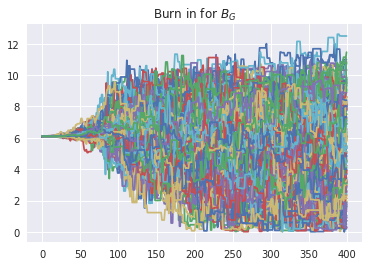

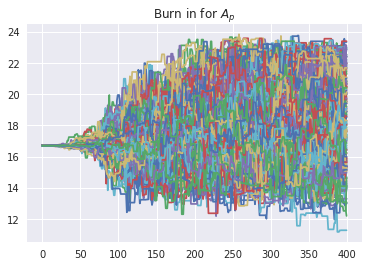

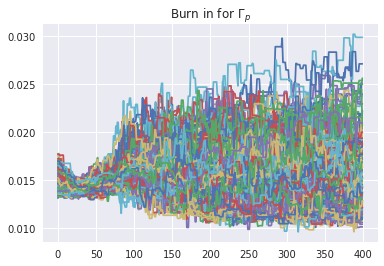

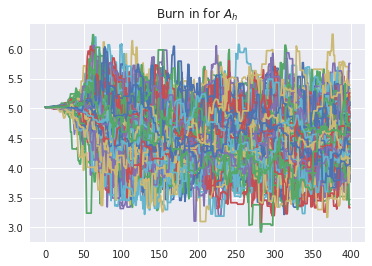

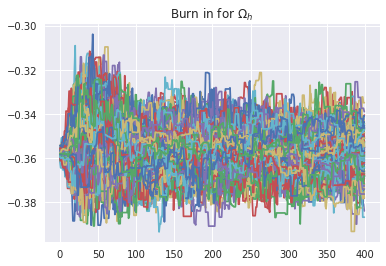

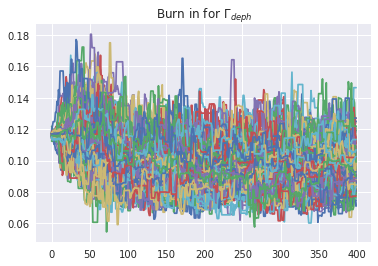

In [28]:
rr_model.plot_params_burnin(test_samples, numwalkers)

From the plot, it looks like the burn-in time is approximately around 200 steps so let's remove all the samples before that. Reshape the samples so the highest-level indices correspond to the parameters that were being varied by the sampler:

In [29]:
#changed burn in time
parameter_samples = rr_model.get_burnin_data(test_samples,burn_in_time=300)

We can use seaborn's pairplot in order to plot the relationship between the 6 parameters.

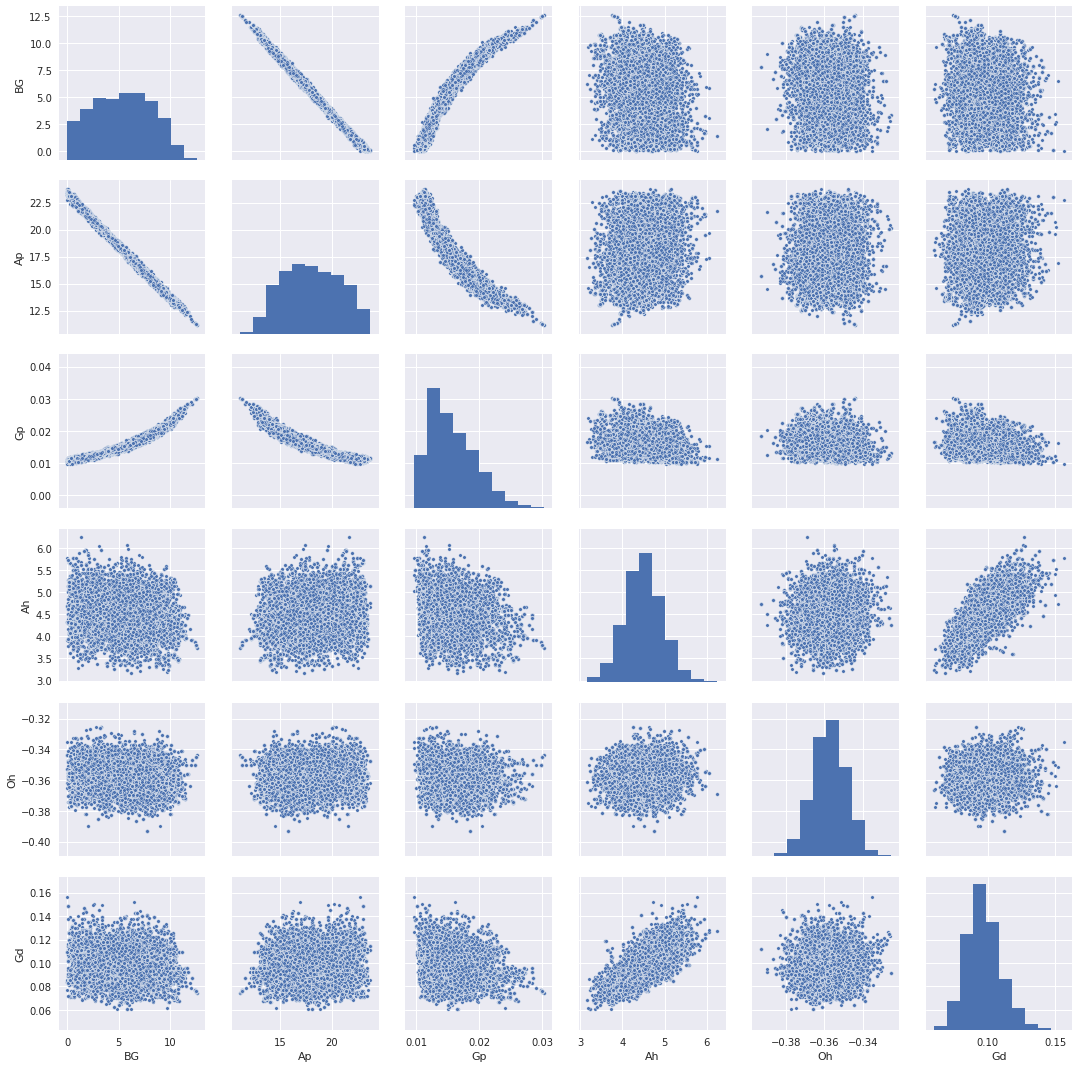

In [30]:
sns.pairplot(parameter_samples, markers='.');

Now tidy up the samples into a DataFrame and use the `DataFrame.quantile` function to find the MAP values of every parameter. Print them out along with the set of parameters you used to generate the data, and see how they match up:

In [31]:
#we find the MAP value of our MCMC analysis
MAP = parameter_samples.quantile([0.50], axis=0)
print('Guesses:')
print(guesses)
print('Calculated MAP values:')
print(MAP)

Guesses:
[ 6.10000000e+00  1.66881000e+01  1.56542049e-02  5.01886000e+00
 -3.58108896e-01  1.16453750e-01]
Calculated MAP values:
           BG         Ap        Gp        Ah        Oh        Gd
0.5  5.437628  18.041923  0.014973  4.492313 -0.357515  0.095805


## MCMC parameter estimation with noise
`rr_model.Walkers` assumes Gaussian noise distribution, but what if we want to account for other types of noise. This package allows you to accommodate for laser drift noise which we refer to as laser skew.

You can call `rr_model.laserskew_Walkers` which includes a laser skew coefficient as a parameter 'a'. Let's repeat our parameter estimation by now incorporating this noise parameter. Since laser skew manifests as an attenuation of the signal, each laser skew parameter will be a weight between 0 and 1. In this example we'll use an initial guess of 0.5 for all laser skew parameters.

In [50]:
# generate some skewed test data first
dataN = 10
runN = 1200
data_length = 20
#np.random.seed(0)
skew_values = np.random.rand(data_length)
theta = np.concatenate( (np.array([6.10, 16.6881,
                                1/63.8806, 5.01886,
                                -np.pi/8.77273, 1/8.5871]),
                            skew_values), axis=0)


np.random.seed(0)
test_data = rr_model.generate_test_data(theta, 161,
                                        data_length, 0, 40, dataN, runN,
                                        include_laserskews=True)
#test_data = rr_model.generate_test_data(theta, 
#                                        161, # number of time steps 
#                                        20, # number of trials
#                                        0, 40, # first and last time point of each trial 
#                                        dataN, runN) # dataN


# a set of test parameter values
#theta_withskew = np.concatenate(
#                (np.array([6.10,            # BG 
#                           16.6881,         # Ap
#                           1/63.8806,       # Gammap
#                           5.01886,         # Ah
#                           -np.pi/8.77273,  # Omegah
#                           1/8.5871]),      # Gammadeph
#                 np.ones(len(test_data))*0.5),axis=0)
theta_withskew = np.concatenate(
                (np.array([6.10,            # BG 
                           16.6881,         # Ap
                           1/63.8806,       # Gammap
                           5.01886,         # Ah
                           -np.pi/8.77273,  # Omegah
                           1/8.5871]),      # Gammadeph
                 skew_values),axis=0)

withskew_loglikelihood = rr_model.general_loglikelihood(theta, mN1_data, time_min, time_max, True, dataN, runN, 100*100)
print("Log likelihood with laser skew:", withskew_loglikelihood)
#print(theta_withskew)

Log likelihood with laser skew: -11100.835663776408
[ 6.10000000e+00  1.66881000e+01  1.56542049e-02  5.01886000e+00
 -3.58108896e-01  1.16453750e-01  6.04049424e-01  8.36807635e-01
  2.28482966e-01  4.95514752e-01  7.74052926e-01  1.75577479e-01
  1.52561143e-01  9.05045869e-01  6.94646651e-01  7.36573363e-01
  8.43968628e-01  5.39425781e-01  4.88405499e-01  5.56257352e-01
  7.17017969e-01  3.90937305e-01  9.51682467e-02  1.35596885e-01
  9.73902958e-01  5.17176623e-02]


Now let's set up priors explicitly for each parameter. Since these data are for $m_N = +1$, we need $B_G > 0$, $A_p > 0$, $\Gamma_p > 0$, $A_h > 0$, $\Gamma_{deph} > 0$, and $0 < a_i < 1$. `log_prior` expects `priors` to consist of a list of lists. Each sublist specifies the type of prior to use for the corresponding parameter in `theta`, which contains the parameters in the order $B_G,A_p,\Gamma_p,A_h,\Omega_h,\Gamma_{deph}$, followed by the laser skew parameters. The two types of priors are: 
* "uniform", in which case the sublist should contain two additional elements, the lower and upper limits between which the prior should be uniform. The value of the log prior for this parameter will then be 0 within those limits and -inf outside of those limits.
* "flat", which is simply a flat improper prior without any limits. The value of the log prior for this parameter will be 0 no matter what.

In [46]:
laserskew_priors = [  ['uniform',0,+np.inf], # BG
                      ['uniform',0,+np.inf], # Ap
                      ['uniform',0.0,+np.inf], # Gammap
                      ['uniform',0,+np.inf], # Ah
                      ['uniform',-np.inf, 0],# Omegah
                      ['uniform',0.0,+np.inf]] # Gammadeph

laserskew_priors = laserskew_priors + [['uniform',0,1]]*len(test_data)

Now try out parameter estimation with laser skews with `rr_model.Walkers_Sampler`:

In [60]:
#added more walkers and
runN = 1200
guesses_withskew = theta_withskew
#print(guesses_withskew)
numdim = len(guesses_withskew)
gaus_var = 1e-3
numwalkers = 200 #this isn't too many walkers, but just to keep this tutorial short to run
numsteps = 1000 #this isn't too many steps, but just to keep this tutorial short to run
test_samples_withskew = rr_model.Walkers_Sampler(test_data, guesses_withskew, 0, 40, False, dataN, runN, 
                                gaus_var, nwalkers=numwalkers, nsteps=numsteps, scale_factor=100*100,
                                withlaserskew=True,priors=laserskew_priors)

[ 6.10000000e+00  1.66881000e+01  1.56542049e-02  5.01886000e+00
 -3.58108896e-01  1.16453750e-01  6.04049424e-01  8.36807635e-01
  2.28482966e-01  4.95514752e-01  7.74052926e-01  1.75577479e-01
  1.52561143e-01  9.05045869e-01  6.94646651e-01  7.36573363e-01
  8.43968628e-01  5.39425781e-01  4.88405499e-01  5.56257352e-01
  7.17017969e-01  3.90937305e-01  9.51682467e-02  1.35596885e-01
  9.73902958e-01  5.17176623e-02]


Guesses:
[ 6.10000000e+00  1.66881000e+01  1.56542049e-02  5.01886000e+00
 -3.58108896e-01  1.16453750e-01]
Calculated MAP values:
           BG         Ap        Gp        Ah        Oh        Gd
0.5  5.460854  18.001237  0.015072  4.488232 -0.357421  0.096061


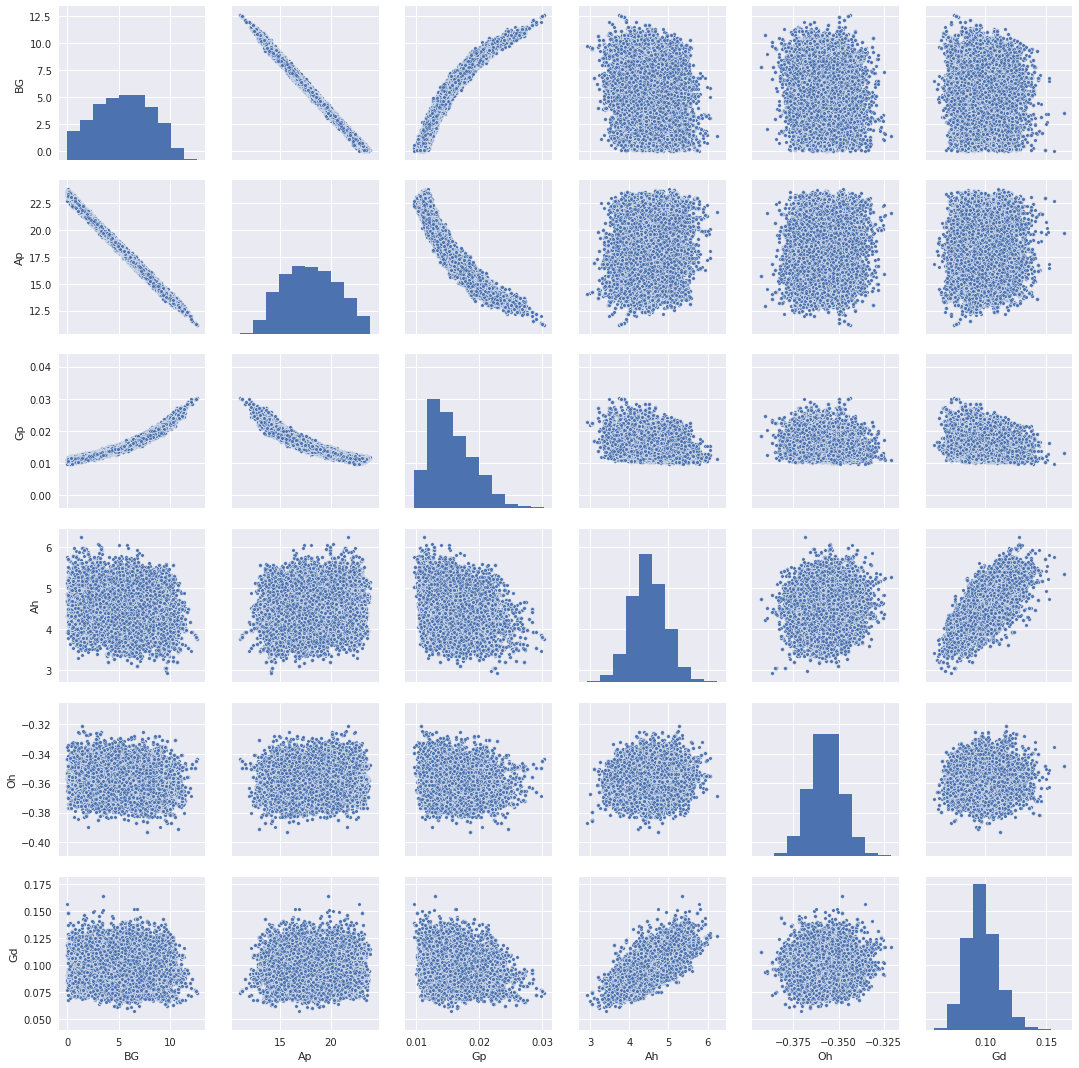

In [61]:
parameter_samples = rr_model.get_burnin_data(test_samples,burn_in_time=200)
sns.pairplot(parameter_samples, markers='.');

#we find the MAP value of our MCMC analysis
MAP = parameter_samples.quantile([0.50], axis=0)
print('Guesses:')
print(guesses)
print('Calculated MAP values:')
print(MAP)

### Check burn-in time
Remember we have an extra parameter this time!

In [59]:
rr_model.plot_params_burnin(test_samples_withskew, numwalkers, withlaserskew = True)

/home/taylor/Documents/Classes/Data Analysis/Final Project/raman_rabi/raman_rabi/rr_model.py:307: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  df = sampler_to_dataframe(sampler, withlaserskew)
/home/taylor/anaconda3/lib/python3.6/site-packages/pandas/core/panel.py:1255: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  return super(Panel, self).

ValueError: Length mismatch: Expected axis has 26 elements, new values have 7 elements

Again, it looks like the burn-in time is approximately around 300 steps so let's remove all the samples before and Reshape the samples so the highest-level indices correspond to the parameters that were being varied by the sampler:

In [ ]:
parameter_samples_withskew = rr_model.get_burnin_data(test_samples_withskew, burn_in_time = 300, withlaserskew = True)

### Plot parameter relationships

Now plot the relationship between the 7 parameters

In [ ]:
sns.pairplot(parameter_samples_withskew, markers='.');

Now tidy up the samples into a DataFrame and use the `DataFrame.quantile` function to find the MAP values of every parameter.

In [ ]:
#we find the MAP value of our MCMC analysis
MAP = parameter_samples_withskew.quantile([0.50], axis=0)
print('Guesses:')
print(guesses_withskew)
print('Calculated MAP values with skew:')
print(MAP)

In [ ]:
test = -np.inf
print(np.isnan(test))
print(not np.isfinite(test))